In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import load_model
import os
import tensorflow as tf


In [ ]:
!unzip "/content/RGB.zip" -d "/content/RGB/"

Archive:  /content/RGB.zip
   creating: /content/RGB/RGB/test/
   creating: /content/RGB/RGB/test/Humidity_Autumn/
  inflating: /content/RGB/RGB/test/Humidity_Autumn/Humidity_RGB47.png  
  inflating: /content/RGB/RGB/test/Humidity_Autumn/Humidity_RGB48.png  
  inflating: /content/RGB/RGB/test/Humidity_Autumn/Humidity_RGB49.png  
  inflating: /content/RGB/RGB/test/Humidity_Autumn/Humidity_RGB50.png  
  inflating: /content/RGB/RGB/test/Humidity_Autumn/Humidity_RGB51.png  
  inflating: /content/RGB/RGB/test/Humidity_Autumn/Humidity_RGB52.png  
  inflating: /content/RGB/RGB/test/Humidity_Autumn/Humidity_RGB53.png  
  inflating: /content/RGB/RGB/test/Humidity_Autumn/Humidity_RGB54.png  
  inflating: /content/RGB/RGB/test/Humidity_Autumn/Humidity_RGB55.png  
  inflating: /content/RGB/RGB/test/Humidity_Autumn/Humidity_RGB56.png  
  inflating: /content/RGB/RGB/test/Humidity_Autumn/Humidity_RGB57.png  
  inflating: /content/RGB/RGB/test/Humidity_Autumn/Humidity_RGB58.png  
  inflating: /content

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/RGB/RGB/train'
valid_path = '/content/RGB/RGB/test'

In [ ]:
# Import the mobilenet library as shown below and add preprocessing layer to the front of MobileNet
# Here we will be using imagenet weights

mobinet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in mobinet.layers[0:len(mobinet.layers)-2]:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('/content/RGB/RGB/train/*')

In [ ]:
print(len(folders))

12


In [ ]:
# our layers - you can add more if you want
x = Flatten()(mobinet.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
mobinet_seasons = Model(inputs=mobinet.input, outputs=prediction)

In [ ]:
# tell the model what cost and optimization method to use
mobinet_seasons.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 786 images belonging to 12 classes.
Found 239 images belonging to 12 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
history_mobinet_seasons = mobinet_seasons.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)    

mobinet_seasons.save('mobinet_seasons_model.h5')


Epoch 1/100
25/25 [==============================] - 29s 777ms/step - loss: 15.8845 - accuracy: 0.0712 - val_loss: 10.6697 - val_accuracy: 0.0795
Epoch 2/100
25/25 [==============================] - 18s 713ms/step - loss: 8.1062 - accuracy: 0.1463 - val_loss: 5.8476 - val_accuracy: 0.0921
Epoch 3/100
25/25 [==============================] - 19s 751ms/step - loss: 4.3975 - accuracy: 0.2519 - val_loss: 6.4114 - val_accuracy: 0.0795
Epoch 4/100
25/25 [==============================] - 18s 724ms/step - loss: 4.0747 - accuracy: 0.3066 - val_loss: 6.7462 - val_accuracy: 0.0711
Epoch 5/100
25/25 [==============================] - 19s 750ms/step - loss: 3.7097 - accuracy: 0.3601 - val_loss: 7.4451 - val_accuracy: 0.0628
Epoch 6/100
25/25 [==============================] - 18s 709ms/step - loss: 2.8464 - accuracy: 0.4453 - val_loss: 7.9819 - val_accuracy: 0.0879
Epoch 7/100
25/25 [==============================] - 18s 712ms/step - loss: 3.0148 - accuracy: 0.4313 - val_loss: 7.1445 - val_accurac

In [ ]:
test_model = load_model('mobinet_seasons_model.h5')

In [ ]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_data_generator = test_generator.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)


Found 239 images belonging to 12 classes.


In [ ]:
Y_preds = test_model.predict(test_data_generator, steps=test_steps_per_epoch)


8/8 [==============================] - 3s 296ms/step


In [ ]:
# Get most likely class
predicted_classes = np.argmax(Y_preds, axis=1)

print(test_data_generator.classes)
print(predicted_classes)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11]
[ 2  0  2  5  2 10  5  7  7  5  2  7  1  7  3  7 10 11  5  7 11  0  2  0
 10  0  7  5  2  7  7 11  2  0  6  3  2 10 11  5  1 11  7  2  7  2  2  2
 10 10 10  1  0  1  0  5  7  1  3  2  2  2  5 10  2  2  2 11 11 11 11  5
  0  2  7  3  2 10  5 10  2  3  2  3  7 11  2  7  2 1

In [ ]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
cmat = confusion_matrix(true_classes, predicted_classes)
acc = accuracy_score(true_classes, predicted_classes)
print(report) 
print(cmat)
print(acc)

                    precision    recall  f1-score   support

   Humidity_Autumn       0.07      0.05      0.06        20
   Humidity_Spring       0.00      0.00      0.00        20
   Humidity_Summer       0.07      0.21      0.10        19
   Humidity_Winter       0.03      0.05      0.04        20
   Moisture_Autumn       0.00      0.00      0.00        20
   Moisture_Spring       0.15      0.20      0.17        20
   Moisture_Summer       0.00      0.00      0.00        20
   Moisture_Winter       0.12      0.20      0.15        20
Temperature_Autumn       0.00      0.00      0.00        20
Temperature_Spring       0.50      0.05      0.09        20
Temperature_Summer       0.04      0.05      0.04        20
Temperature_Winter       0.09      0.10      0.10        20

          accuracy                           0.08       239
         macro avg       0.09      0.08      0.06       239
      weighted avg       0.09      0.08      0.06       239

[[1 1 4 1 0 4 0 6 0 0 2 1]
 [4 0 4 1 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


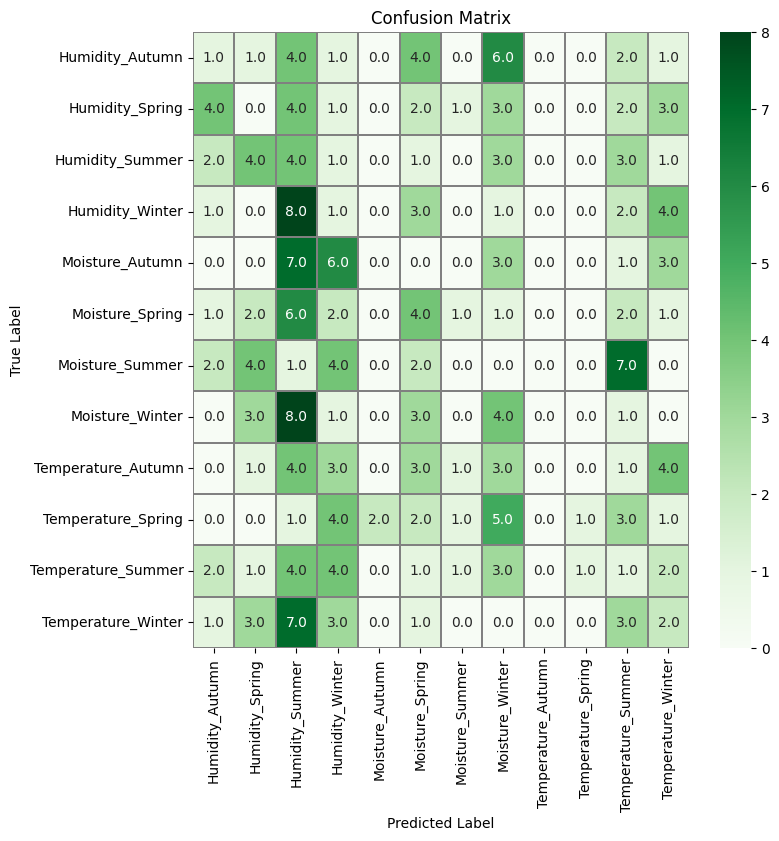

In [ ]:
confusion_mtx = confusion_matrix(true_classes, predicted_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#ax.set_xticklabels(['Apple_Healthy','Orange_Healthy'])
ax.set_xticklabels(['Humidity_Autumn','Humidity_Spring','Humidity_Summer','Humidity_Winter','Moisture_Autumn','Moisture_Spring','Moisture_Summer','Moisture_Winter','Temperature_Autumn','Temperature_Spring','Temperature_Summer','Temperature_Winter'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
#ax.set_yticklabels(['Aypple_Health','Orange_Healthy'])
ax.set_yticklabels(['Humidity_Autumn','Humidity_Spring','Humidity_Summer','Humidity_Winter','Moisture_Autumn','Moisture_Spring','Moisture_Summer','Moisture_Winter','Temperature_Autumn','Temperature_Spring','Temperature_Summer','Temperature_Winter'])
plt.title("Confusion Matrix")
plt.show()